
=== Sample Predictions ===
                                             log_text              label  \
0   Extended taxi-in due to temporary runway closu...    ATC_RESTRICTION   
1   Holding pattern caused by ATC congestion over ...    ATC_RESTRICTION   
2   Passenger screening issue caused departure gat...           SECURITY   
3   Flight crew delayed in transit from inbound co...         CREW_DELAY   
4   Departure delayed due to low visibility and st...            WEATHER   
5   Flight crew delayed in transit from inbound co...         CREW_DELAY   
6   Late pushback due to avionics panel issue disc...  TECHNICAL_FAILURE   
7   Security clearance delay due to unattended bag...           SECURITY   
8   Missing ground power unit required last-minute...    LOGISTICS_ISSUE   
9   Late pushback due to nose gear issue discovere...  TECHNICAL_FAILURE   
10  Flight crew delayed in transit from inbound co...         CREW_DELAY   
11  Late pushback due to nose gear issue discovere...  TECHN

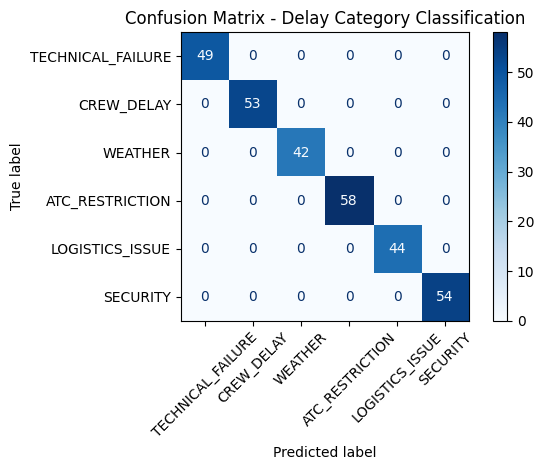


=== Extended Inference Example ===
Text: Late pushback due to hydraulic pump issue discovered during final check.
Predicted Category: TECHNICAL_FAILURE
Confidence Scores: {'TECHNICAL_FAILURE': 0.774, 'CREW_DELAY': 0.038, 'WEATHER': 0.053, 'ATC_RESTRICTION': 0.046, 'LOGISTICS_ISSUE': 0.063, 'SECURITY': 0.026}
Predicted Phase: final check
Predictability: UNPREDICTABLE

=== Classification Report - Phase Prediction ===
               precision    recall  f1-score   support

     taxi-out       0.83      1.00      0.91        10
     pushback       0.67      1.00      0.80         8
  final check       1.00      1.00      1.00         9
     boarding       0.00      0.00      0.00         6
pre-departure       0.75      1.00      0.86        12
 engine start       0.00      0.00      0.00         4

     accuracy                           0.80        49
    macro avg       0.54      0.67      0.59        49
 weighted avg       0.65      0.80      0.71        49



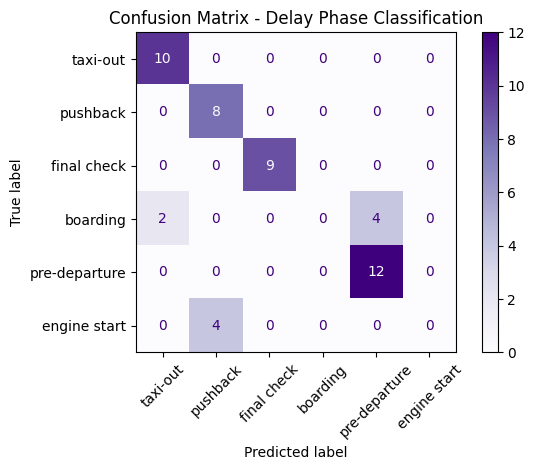

In [8]:
# Aircraft Delay Log - Inference & Evaluation (Unified Version)

import torch
import pandas as pd
import warnings
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# === Load data ===
df = pd.read_csv('../data/synthetic_logs.csv')
df = df.sample(frac=1.0).reset_index(drop=True)

# === Load label map ===
label_map = {
    0: "TECHNICAL_FAILURE",
    1: "CREW_DELAY",
    2: "WEATHER",
    3: "ATC_RESTRICTION",
    4: "LOGISTICS_ISSUE",
    5: "SECURITY"
}
reverse_label_map = {v: k for k, v in label_map.items()}

# === Load phase map ===
with open("../model/phase_map.json") as f:
    raw_phase_map = json.load(f)
# raw_phase_map: {"taxi-out": 0, "boarding": 1, ...}
phase_map = {v: k for k, v in raw_phase_map.items()}  # {0: "taxi-out", ...}
reverse_phase_map = raw_phase_map  # {"taxi-out": 0, ...}


# === Load models & tokenizer ===
tokenizer = AutoTokenizer.from_pretrained("../model/delay_phase_classifier")  # same tokenizer for both
label_model = AutoModelForSequenceClassification.from_pretrained("../model/delay_classifier")
phase_model = AutoModelForSequenceClassification.from_pretrained("../model/delay_phase_classifier")
label_model.eval()
phase_model.eval()

# === Predict functions ===
def predict_label(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = label_model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).squeeze().tolist()
        pred_idx = torch.argmax(outputs.logits, dim=1).item()
    return label_map[pred_idx], probs

def predict_phase(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = phase_model(**inputs)
        pred_idx = torch.argmax(outputs.logits, dim=1).item()
    return phase_map[pred_idx]

def is_predictable(label):
    predictable = {"WEATHER", "CREW_DELAY", "LOGISTICS_ISSUE"}
    return "PREDICTABLE" if label in predictable else "UNPREDICTABLE"

def batch_predict_labels(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = label_model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).tolist()
    return [label_map[p] for p in preds]

# === Quick test set inference ===
df_test = df[:20].copy()
df_test["predicted_label"] = batch_predict_labels(df_test["log_text"].tolist())

print("\n=== Sample Predictions ===")
print(df_test[["log_text", "label", "predicted_label"]])

# === Full evaluation for Delay Category ===
df["label_id"] = df["label"].map(reverse_label_map)
y_true = df["label_id"].tolist()
y_pred = batch_predict_labels(df["log_text"].tolist())
y_pred_ids = [reverse_label_map[p] for p in y_pred]

target_names = [label_map[i] for i in range(len(label_map))]

print("\n=== Classification Report - Delay Category ===")
print(classification_report(y_true, y_pred_ids, target_names=target_names))

cm = confusion_matrix(y_true, y_pred_ids)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.values())
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix - Delay Category Classification")
plt.tight_layout()
plt.show()

# === Example: Extended Inference ===
example_text = "Late pushback due to hydraulic pump issue discovered during final check."

label, label_probs = predict_label(example_text)
phase = predict_phase(example_text)
predictability = is_predictable(label)

print("\n=== Extended Inference Example ===")
print("Text:", example_text)
print("Predicted Category:", label)
print("Confidence Scores:", dict(zip(label_map.values(), [round(p, 3) for p in label_probs])))
print("Predicted Phase:", phase)
print("Predictability:", predictability)

# === Phase Evaluation ===
df_phase = df.dropna(subset=["phase"]).copy()
df_phase["phase_id"] = df_phase["phase"].map(reverse_phase_map)
y_true_phase = df_phase["phase_id"].tolist()

texts_phase = df_phase["log_text"].tolist()
y_pred_phase_labels = [predict_phase(text) for text in texts_phase]
y_pred_phase_ids = [reverse_phase_map[p] for p in y_pred_phase_labels]

phase_target_names = [phase_map[i] for i in range(len(phase_map))]

print("\n=== Classification Report - Phase Prediction ===")
print(classification_report(y_true_phase, y_pred_phase_ids, target_names=phase_target_names))

cm_phase = confusion_matrix(y_true_phase, y_pred_phase_ids)
disp_phase = ConfusionMatrixDisplay(confusion_matrix=cm_phase, display_labels=phase_target_names)
disp_phase.plot(xticks_rotation=45, cmap="Purples")
plt.title("Confusion Matrix - Delay Phase Classification")
plt.tight_layout()
plt.show()
